# 1. Introduction

我們所分析的為時間序列問題，檢附的數據為管線輸送時候的流量、壓力等參數。

請使用附件的數據，將B和I欄位的數據作微分，微分後數值回寫到J和K欄位；
再利用J和K的數值，進行操作狀況的分類。

我們需要從微分數值，分類管線操作在何種狀態下：穩定輸送、開始輸送、停止輸送、閥門操作、儲槽切換
如果微分數值彼此間有顯著的差異，就可以定義微分數據變動的當下，就是操作狀態變動的時間點

分類的時候可能需要time window的設定，可以先設定20秒。
請稍微整理一下本數據可以分為幾類，每類的B和I欄位原始數據pattern長怎樣(請不要太複雜)。

這個問題沒有正確答案，只是想看看您對python的熟悉度，以及方法使用的思考。

#2. Process

***1. Exploring data analysis:***

- 分析time series, 觀察其pattern: tend, seasonality...
- 資料分布狀態
- Visualization

***2. Differentiated the feature B & I***

***3. 分析此 differentiated data:***

- 是否為Stationary time series? ADF-test

    if does, capture trend and seasonality.

    if necessary, analyze by autocorrelation plot

- frequency(seasonality), 也就是time window 設定多少? (題目先假設20)

***4. Classification:***

*This is an unsupervised learning
, utilized 'Clustering'*


- *Feature selection:*

    (1) Differentiated column B
    
    (2) Differentiated column I
    
    *(3) Seasonality B

    *(4) Seasonality I

    '*' 表示此特徵為new-generated  

- *KMeans:*

    若使用Feature (1) & Feature (2)建構出的feature space(dimension=2)進行KMeans clustering, 較無法解釋每個cluster之間cohesion和分類表準。因此新增feature(3) 和 (4), 預期能藉由time series的seasonality對此feature space(dimension=4)的clustering有較好的解釋

- *DBSCAN:*

How to choose $\epsilon$ $\rightarrow$ required domain knowledge, the quality of DBSCAN depends on the distance measure used in the function region $Query(P, \epsilon)$

- *Expectation Maximum algorthim:*

    Generative model
    
    Since the differentiated data and raw pattern of the non-differentiated data present similarly to gaussian distribution, Gaussian mixture model may help increasing clustering performance.

***5. Metrics & Grid search***

- *Metrics for clustering:*

    Silhouette score, i.e the ratio of cohesion(within-cluster distance) to intra-cluster distance.

- *Grid search:*

    As mentioned, time window(period) is rearded as an importance parameter. Here, I select the parameter,  start from 20, and end with 120, see if (1)the seasonality capture from the time window and (2) the clustering algorithm (KMeans, EM, DBSCAN) are significant to clustering or not.


# Read in data

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/'

import requests
import os

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath


def start_plot(figsize=(10, 8), style = 'whitegrid', dpi=100):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def grid_plot(figsize=(18, 14), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    # plt.tight_layout()
    gs=fig.add_gridspec(2, 2)
    with sns.axes_style(style):
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[1,0])  
        ax3 = fig.add_subplot(gs[1,1]) 
    return [ax0, ax1, ax2, ax3]

data_dir = groot_dir + 'itri/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv(os.path.join(data_dir, 'transport.csv'), parse_dates=['時間'])
data.rename(columns={'時間': 'TIME'}, inplace=True)
data.set_index('TIME', inplace=True)
data.head()

XY8002FR  XY8002TI   XY8002PI  TB8002PIB  TB8004PI  \
TIME                                                                       
2021-05-01 00:00:00  82.389222  26.79149  15.947178   8.715559  7.709773   
2021-05-01 00:00:01  82.381760  26.79149  15.941900   8.717367  7.710905   
2021-05-01 00:00:02  82.407649  26.84095  15.948680   8.715977  7.709569   
2021-05-01 00:00:03  82.392084  26.84095  15.950853   8.715723  7.710202   
2021-05-01 00:00:04  82.410602  26.83163  15.948300   8.715945  7.710315   

                     MX8004PIB   MX8004TI   MX8004FR  
TIME                                                  
2021-05-01 00:00:00   2.716009  15.523539  81.789219  
2021-05-01 00:00:01   2.714535  15.539738  81.695330  
2021-05-01 00:00:02   2.718486  15.521860  81.584007  
2021-05-01 00:00:03   2.714572  15.531535  81.811499  
2021-05-01 00:00:04   2.714224  15.529200  81.751831

In [ ]:
data.shape

(86400, 8)

## 1. Plot the raw data

### Line plot

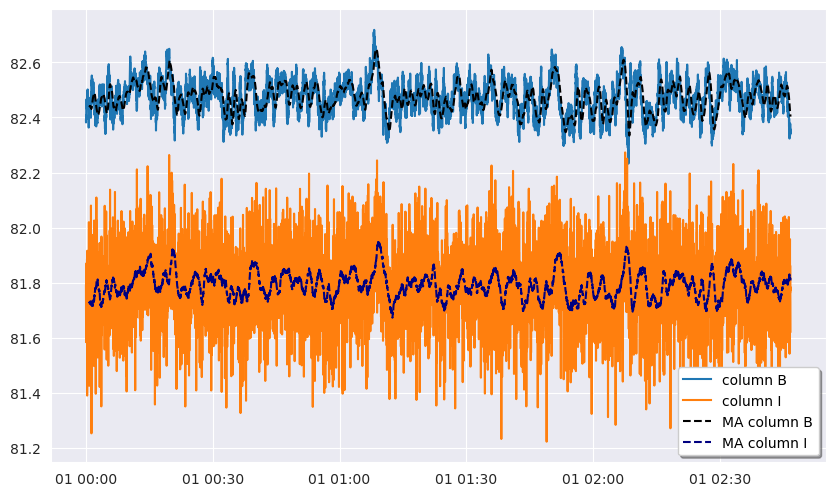

In [4]:
b_time = data['XY8002FR']
i_time = data['MX8004FR']

ax = start_plot(figsize=(10, 6), style='darkgrid')

## Too scattered
ax.plot(b_time[:10000], label='column B')
ax.plot(i_time[:10000], label='column I')

## Smoothing & take the first 10000 data for visualization
ax.plot(b_time.rolling(window=50).mean()[:10000], label='MA column B', c='k', ls='--')
ax.plot(i_time.rolling(window=50).mean()[:10000], label='MA column I', c='navy', ls='--')

ax.legend(shadow=True)

GROUPBY 每分鐘，觀察每分鐘的趨勢

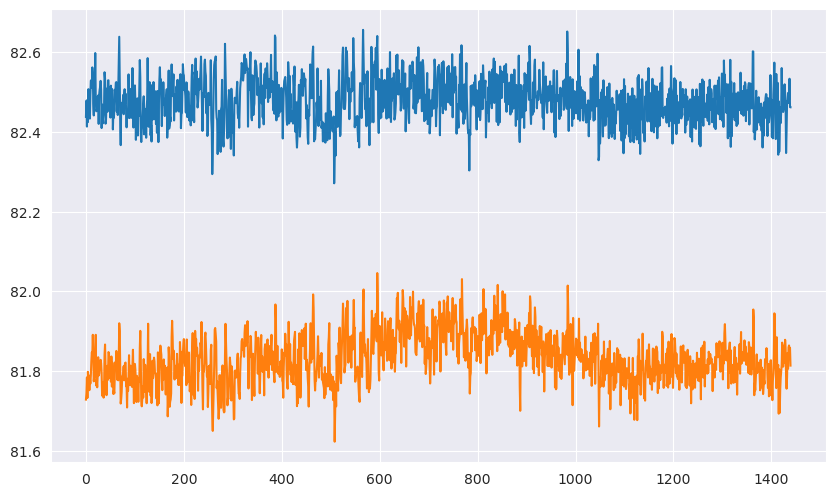

In [5]:
ax = start_plot(figsize=(10, 6), style='darkgrid')

## Too scattered
ax.plot(b_time.groupby([b_time.index.hour, b_time.index.minute]).mean().values,
        label='column B')
ax.plot(i_time.groupby([i_time.index.hour, i_time.index.minute]).mean().values,
        label='column I')

### Distribution plot

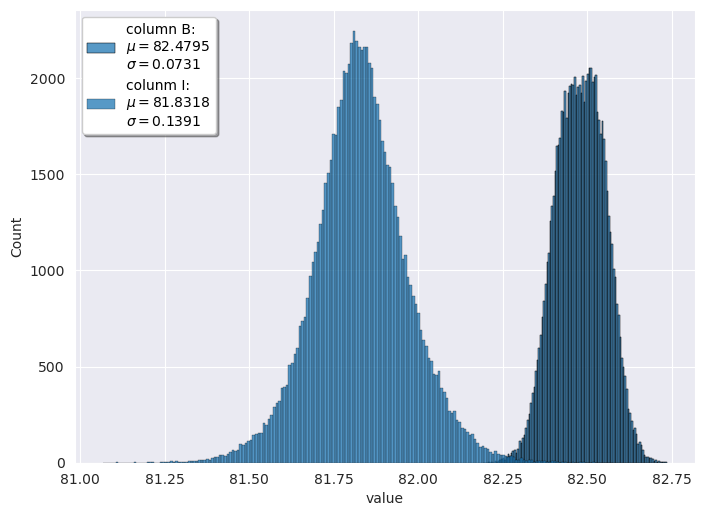

In [6]:
ax = start_plot(figsize=(8, 6), style='darkgrid')
sns.histplot(b_time, label='column B: ' + '\n$\mu = %.4f$' % b_time.mean()
                      + '\n$\sigma = %.4f$' % b_time.std())
sns.histplot(i_time, label='colunm I: ' + '\n$\mu = %.4f$' % i_time.mean()
                      + '\n$\sigma = %.4f$' % i_time.std())

ax.set_xlabel('value')
ax.legend(shadow=True)

In [7]:
import scipy

b_test = scipy.stats.shapiro(b_time[-1000:])
i_test = scipy.stats.shapiro(i_time[-1000:])
b_test, i_test

(ShapiroResult(statistic=0.9686479568481445, pvalue=7.315481364124701e-14),
 ShapiroResult(statistic=0.993930459022522, pvalue=0.0004433687136042863))

From this raw time series plot, we could observe that 


*   column B range < column I range

*   B time series & I time series are 'not' Gaussian distribution, since there p-values from Shapiro test > 0.005




# Differential

In [8]:
## Differntiate by time index

b_der_all = pd.Series(np.gradient(b_time.values), b_time.index, name='diff_B')
i_der_all = pd.Series(np.gradient(i_time.values), i_time.index, name='diff_I')


**Capture trend:**

Smoothing

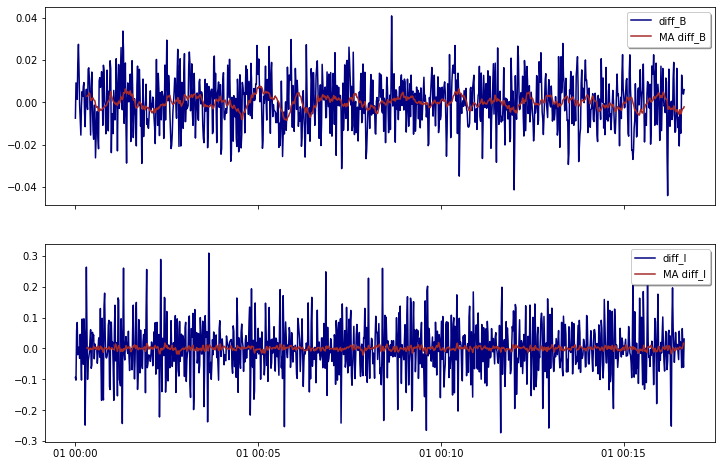

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sliding_window = 20

ax[0].plot(b_der_all[:1000], label='diff_B', color='navy')
ax[0].plot(b_der_all.rolling(window=sliding_window).mean()[:1000], label='MA diff_B', color='brown')
ax[0].legend(shadow=True)

ax[1].plot(i_der_all[:1000], label='diff_I', color='navy')
ax[1].plot(i_der_all.rolling(window=sliding_window).mean()[:1000], label='MA diff_I', color='brown')
ax[1].legend(shadow=True)

利用moving average smoothing 過後，發現diff_B的trend較為noise，而diff_I則比較平緩

將trend remove, 有助於分析時間序列 不同時間點的關聯

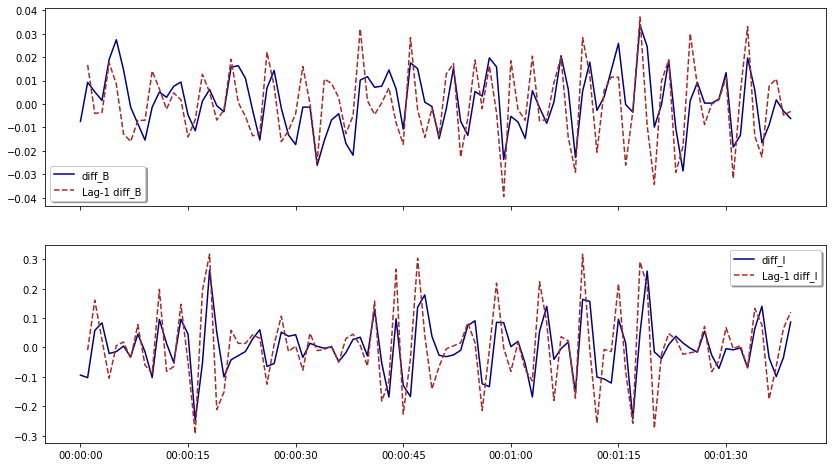

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(b_der_all[:100], label='diff_B', color='navy')
ax[0].plot(b_der_all[:100].diff(1), label='Lag-1 diff_B', color='brown', ls='--')
ax[0].legend(shadow=True)


ax[1].plot(i_der_all[:100], label='diff_I', color='navy')
ax[1].plot(i_der_all[:100].diff(1), label='Lag-1 diff_I', color='brown', ls='--')
ax[1].legend(shadow=True)

## Time series analyis

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Applying Augmented Dickey-Fuller Test

In [ ]:
class StationarityTests:
    
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

By ADF-test, the differentiated features <font color='darkorange'>$diffB$ is considered Stationary<font>

In [ ]:
Tester = StationarityTests()
Tester.ADF_Stationarity_Test(b_der_all, printResults=True)

print('------')
Tester.isStationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -50.068337
P-Value                     0.000000
# Lags Used                66.000000
# Observations Used     86333.000000
Critical Value (1%)        -3.430426
Critical Value (5%)        -2.861573
Critical Value (10%)       -2.566788
dtype: float64
------


True

By ADF-test, the differentiated features <font color='darkorange'>$diffI$ is considered Stationary<font>

In [ ]:
Tester = StationarityTests()
Tester.ADF_Stationarity_Test(i_der_all, printResults=True)

print('------')
Tester.isStationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -49.731977
P-Value                     0.000000
# Lags Used                66.000000
# Observations Used     86333.000000
Critical Value (1%)        -3.430426
Critical Value (5%)        -2.861573
Critical Value (10%)       -2.566788
dtype: float64
------


True

### Deseaonality

#### Differentiated Column B 

time window defined: $M=20$

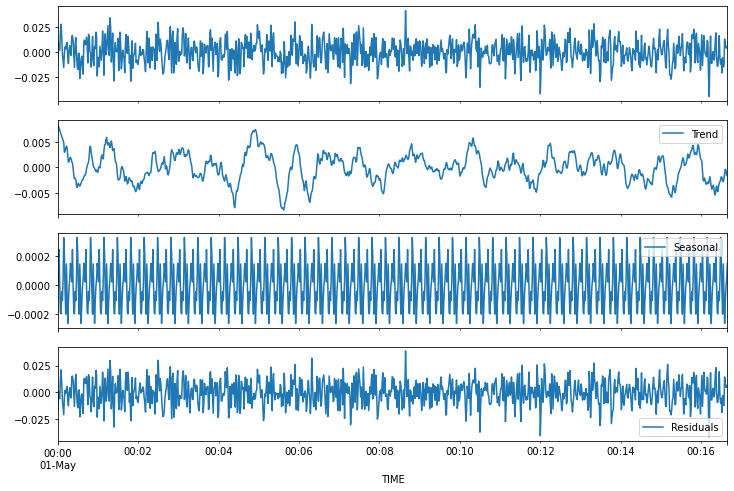

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

b_result = seasonal_decompose(b_der_all, model='additive', extrapolate_trend='freq', period = 20)

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
b_der_all[:1000].plot(ax=ax[0])
b_result.trend[:1000].plot(ax=ax[1])
ax[1].legend(['Trend'], loc='best')
b_result.seasonal[:1000].plot(ax=ax[2])
ax[2].legend(['Seasonal'], loc='best')
b_result.resid[:1000].plot(ax=ax[3])
ax[3].legend(['Residuals'], loc='best')

ADF test for residuals series: expected to be stationary time series as well as the raw pattern

In [ ]:
Tester = StationarityTests()
Tester.ADF_Stationarity_Test(b_result.resid, printResults=True)

print('------')
Tester.isStationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -72.218196
P-Value                     0.000000
# Lags Used                66.000000
# Observations Used     86333.000000
Critical Value (1%)        -3.430426
Critical Value (5%)        -2.861573
Critical Value (10%)       -2.566788
dtype: float64
------


True

#### Differentiated Column I 

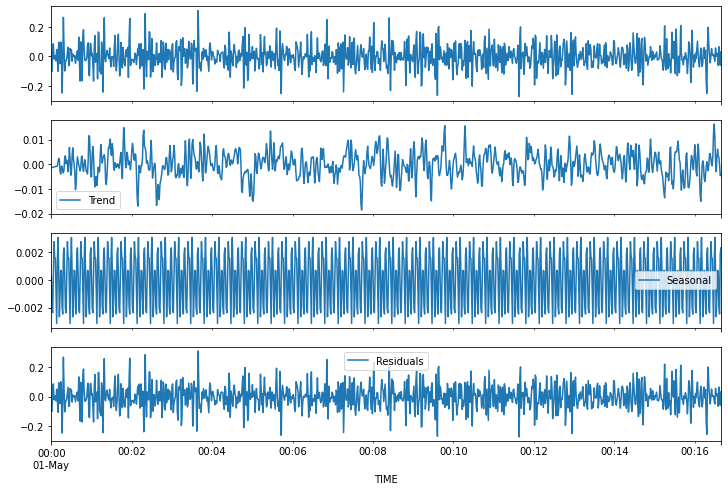

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

i_result = seasonal_decompose(i_der_all, model='additive', extrapolate_trend='freq', period=20)

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
i_der_all[:1000].plot(ax=ax[0])
i_result.trend[:1000].plot(ax=ax[1])
ax[1].legend(['Trend'], loc='best')
i_result.seasonal[:1000].plot(ax=ax[2])
ax[2].legend(['Seasonal'], loc='best')
i_result.resid[:1000].plot(ax=ax[3])
ax[3].legend(['Residuals'], loc='best')

In [ ]:
Tester = StationarityTests()
Tester.ADF_Stationarity_Test(i_result.resid, printResults=True)

print('------')
Tester.isStationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -84.192124
P-Value                     0.000000
# Lags Used                66.000000
# Observations Used     86333.000000
Critical Value (1%)        -3.430426
Critical Value (5%)        -2.861573
Critical Value (10%)       -2.566788
dtype: float64
------


True

#### Observed Autocorrelation 

column B

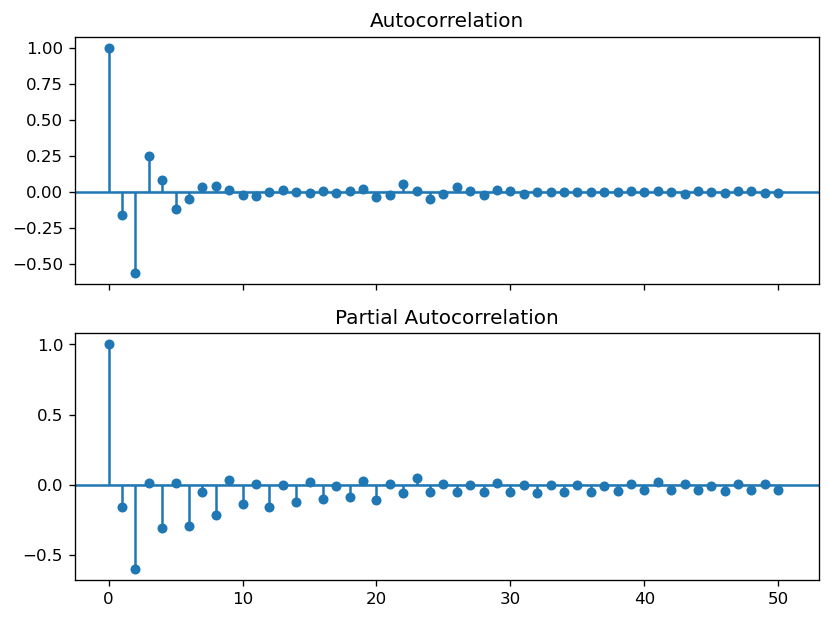

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## differncing 1 for removing trend
b_ = b_der_all.diff(1)[1:]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=120, sharex=True)
plot_acf(b_, lags=50, ax=ax[0])
plot_pacf(b_, lags=50, ax=ax[1])
plt.show()

ACF: lag=2

PACF: lag=2, 4, 6,...

column I

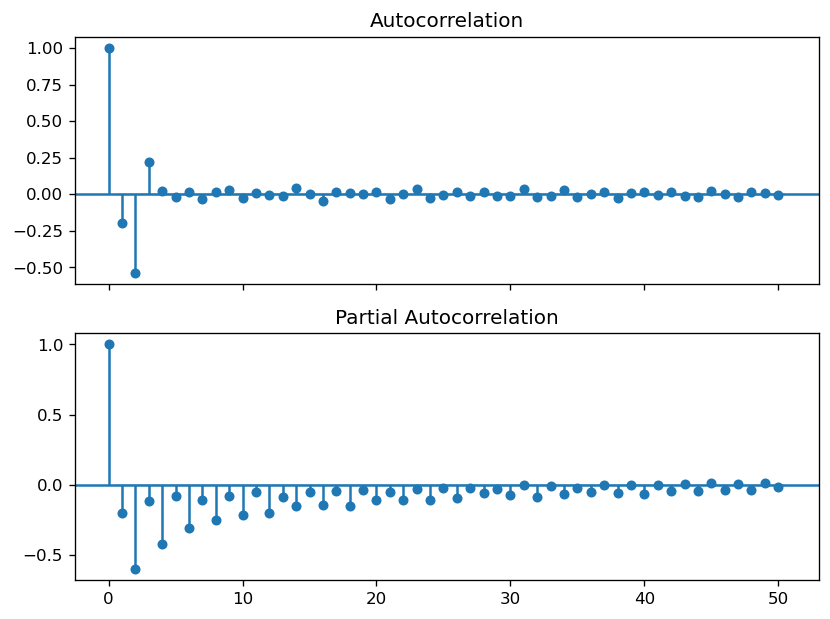

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## differncing 1 for removing trend
i_lag201 = i_der_all.diff(1)[1:]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=120, sharex=True)
plot_acf(i_lag201, lags=50, ax=ax[0])
plot_pacf(i_lag201, lags=50, ax=ax[1])
plt.show()

ACF: lag=2

PACF: lag=2, 4, 6,...

## Classification: Clustering methods

This is an unsupervised-learning issue

What we have to do, is construct the feature space spanned by $diffB$ & $diffI$, the two differentiate columns, and applying clustering methods to classfied.

<font color='yellow'>***Classes:***<font>
* `穩定輸送`

* `開始輸送`

* `停止輸送`

* `閥門操作`

* `儲槽切換`

(86400, 2)


Text(0, 0.5, 'diff I')

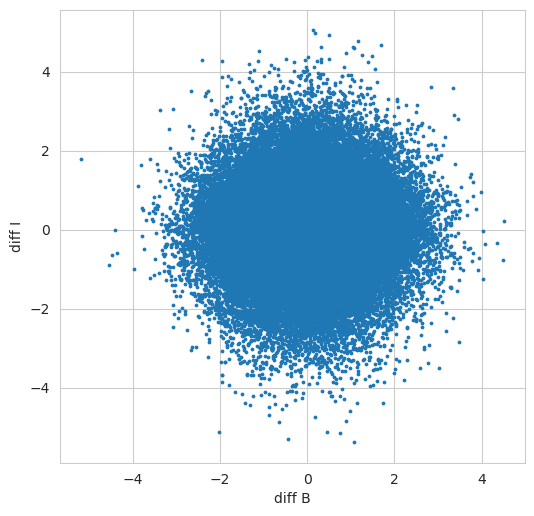

In [12]:
train_df = pd.DataFrame({'diff_B': b_der_all, 'diff_I': i_der_all})
train_df.dropna(axis=0, inplace=True)
print(train_df.shape)
train_df.head()

## Standardization for avoiding scale dominated while clustering in Eucleadian space
df_mean = train_df.mean()
df_std = train_df.std()

std_train_df = (train_df - df_mean) / df_std

ax = start_plot(figsize=(6, 6))
ax.scatter(std_train_df.diff_B, std_train_df.diff_I, s=3)
ax.set_xlabel('diff B')
ax.set_ylabel('diff I')

### 2. KMeans

In [ ]:
def boundries(model, data, resolution = 1000,
    plot_centroids = False, figsize=(12,10), style='whitegrid', rescale=False):

    mins = data.min(axis=0) - 0.01
    maxs = data.max(axis=0) + 0.01
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if rescale is True:
        mins = mins * df_std + df_mean
        maxs = maxs * df_std + df_mean
        # Z = Z * df_std + df_mean
    Z = Z.reshape(xx.shape)


    ax = start_plot(figsize=figsize, style=style, dpi=120)
    
    ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
               cmap="Pastel1", alpha = 0.2)
    ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k', alpha = 0.6)

    # labels = model.predict(data)
    labels = model.labels_

    centroids = model.cluster_centers_

    if rescale is True:
        centroids = centroids * df_std.values + df_mean.values
        data = data * df_std.values + df_mean.values

    ax.scatter(data[:,0], data[:,1], c = labels,
        cmap = 'coolwarm', edgecolor='navy', s=75)
    
    ax.scatter(centroids[:,0], centroids[:,1], marker = 'o',
        s = 220, edgecolor = 'k', c = 'w')
    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker = '$%d$' % i,
            s = 80, edgecolor = 'r')

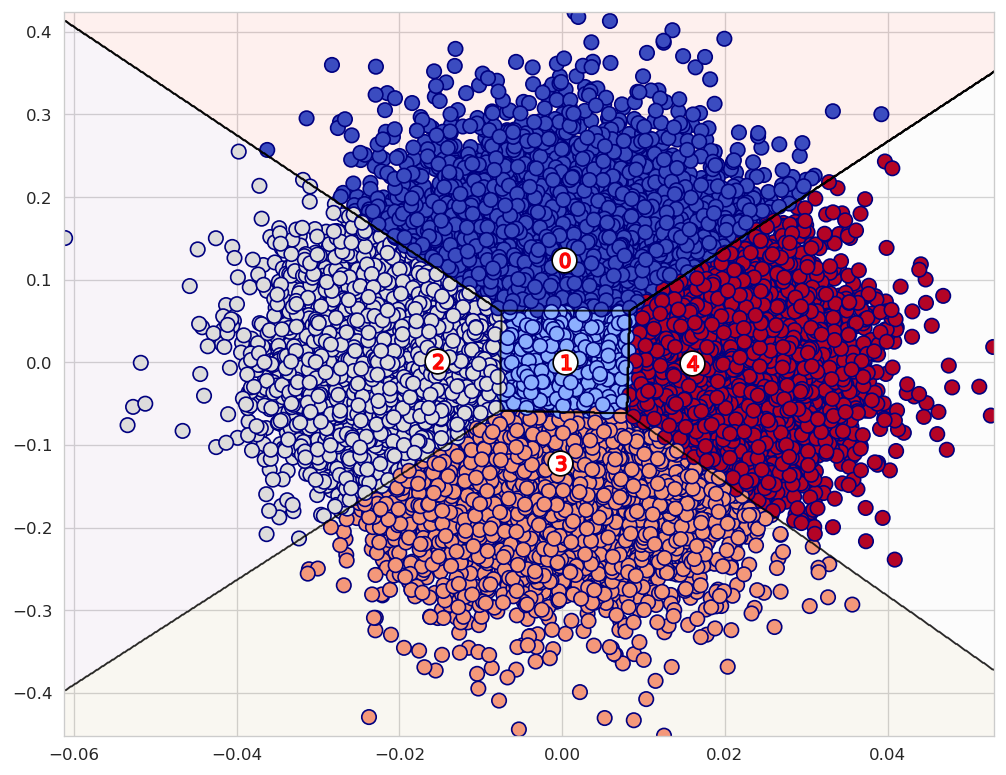

In [ ]:
## meshgrid
from sklearn.cluster import KMeans


n_k = 5
X = std_train_df.values
model = KMeans(n_clusters = n_k).fit(X)
boundries(model, X, style = 'whitegrid', figsize=(10, 8),
    plot_centroids = True, rescale=True)

增加欄位: B 和 I 的seasonality, 期望能使clustering 更加全面

Caution: 此時feature dimension increase to 4 dimensions.

In [13]:
b_seasonal = seasonal_decompose(b_der_all, model='additive', period = 20).seasonal
i_seasonal = seasonal_decompose(i_der_all, model='additive', period = 20).seasonal

tdf = pd.DataFrame({'diff_B': b_der_all, 'diff_I': i_der_all,
           'seasonal_B': b_seasonal, 'seasonal_I': i_seasonal})
tdf.head()

diff_B    diff_I  seasonal_B  seasonal_I
TIME                                                           
2021-05-01 00:00:00 -0.007462 -0.093888    0.000098    0.000313
2021-05-01 00:00:01  0.009213 -0.102606    0.000020   -0.002024
2021-05-01 00:00:02  0.005162  0.058084    0.000245   -0.002382
2021-05-01 00:00:03  0.001476  0.083912   -0.000002    0.000123
2021-05-01 00:00:04  0.019010 -0.020449   -0.000197    0.002745

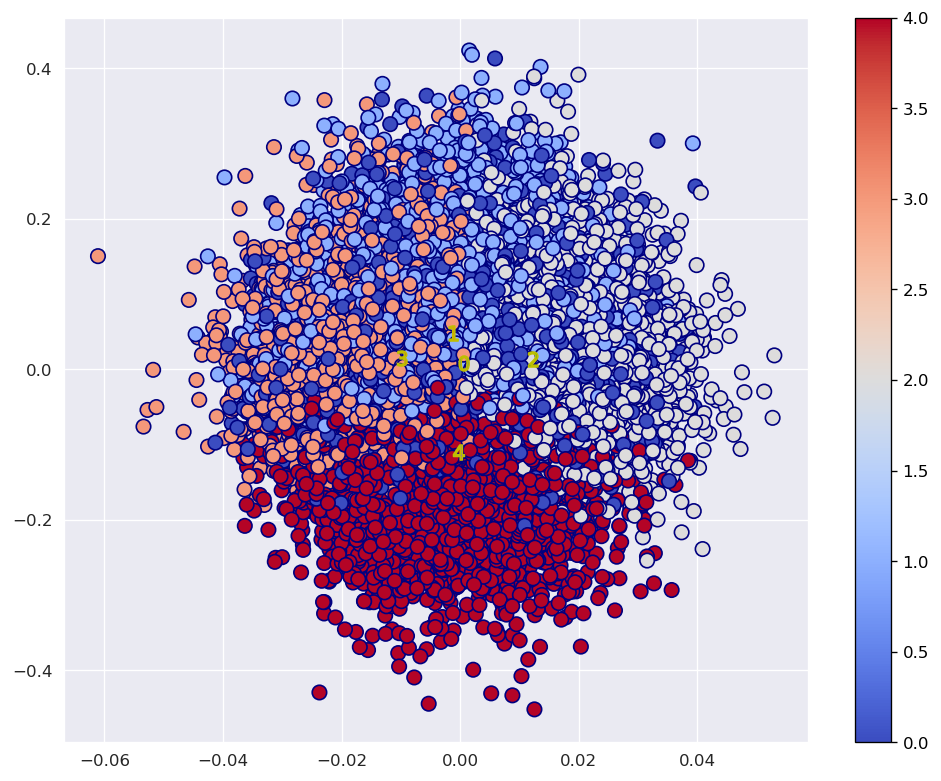

In [17]:
from sklearn.cluster import KMeans

n_k = 5
tdf_mean = tdf.mean()
tdf_std = tdf.std()
std_tdf = (tdf - tdf_mean) / tdf_std

X1 = std_tdf.values

model_1 = KMeans(n_clusters = n_k).fit(X1)
kmeans_labels = model_1.labels_
centroids = model_1.cluster_centers_

ax = start_plot(style='darkgrid', dpi=120)

## Axis for visualization
x_axis = 0
y_axis = 1

## rescale
centroids = centroids * tdf_std.values.reshape(1, -1) + tdf_mean.values.reshape(1, -1)

scatter_plot = ax.scatter(tdf.iloc[:, x_axis], tdf.iloc[:, y_axis], c=kmeans_labels,
      cmap = 'coolwarm', edgecolor='navy', s=75, )

plt.colorbar(scatter_plot, ax=ax)


for i, c in enumerate(centroids):
    ax.scatter(c[x_axis], c[y_axis], marker = '$%d$' % i,
        s = 80, edgecolor = 'y')

### DBSCAN

In [ ]:
%%time

from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.85, min_samples=n_k)
dbscan_labels = dbscan_model.fit_predict(std_tdf.values)

Wall time: 17.1 s


In [ ]:
n_clusters_ = len(set(dbscan_labels)) - 1 if -1 in set(dbscan_labels) else 0
n_noise_ = list(dbscan_labels).count(-1)

print('%d estimated clusters' % n_clusters_)
print('%d noise points' % n_noise_)

5 estimated clusters
39 noise points


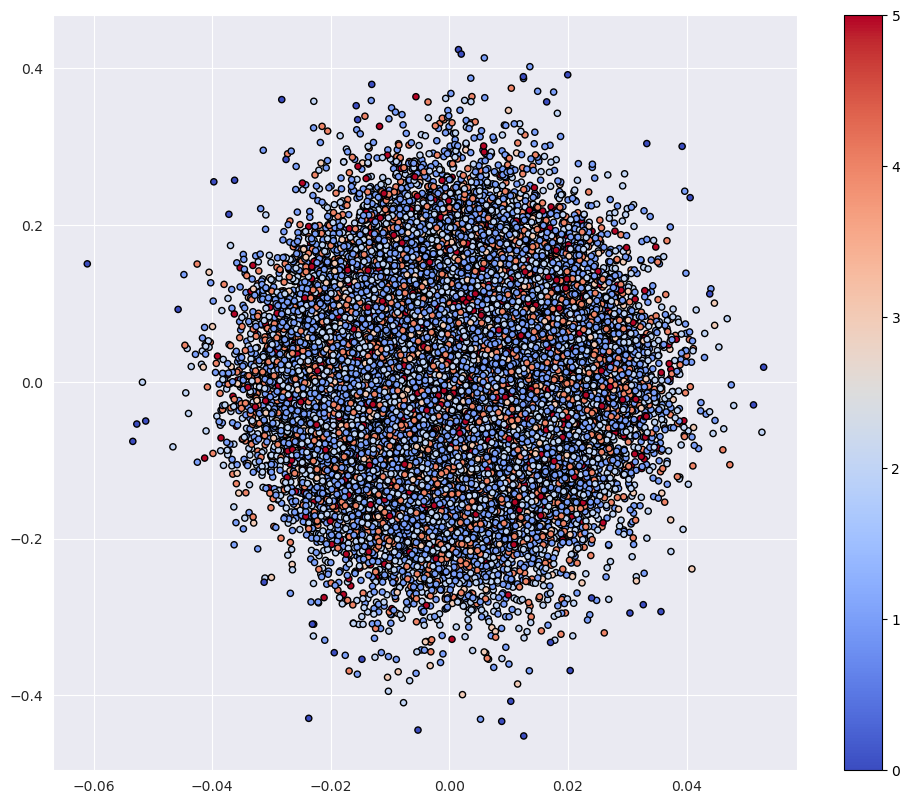

In [ ]:
labels = np.array([x + 1 for x in dbscan_model.labels_])

## Axis for visualization
x_axis = 0
y_axis = 1

ax = start_plot(style='darkgrid', figsize=(12, 10))
scatter_plot = ax.scatter(tdf.iloc[:, x_axis], tdf.iloc[:, y_axis], s=20, edgecolor='k',
           c=labels, cmap='coolwarm')
plt.colorbar(scatter_plot, ax=ax)
for c, p in zip(labels, tdf):
    if c != 0:
        continue
    ax.scatter(p[x_axis], p[y_axis], color='yellow', marker='X', s=100, edgecolor='yellow')

### EM algorithm

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_k)
gmm.fit(std_tdf)
gmm_labels = gmm.predict(std_tdf)
probs = gmm.predict_proba(std_tdf)

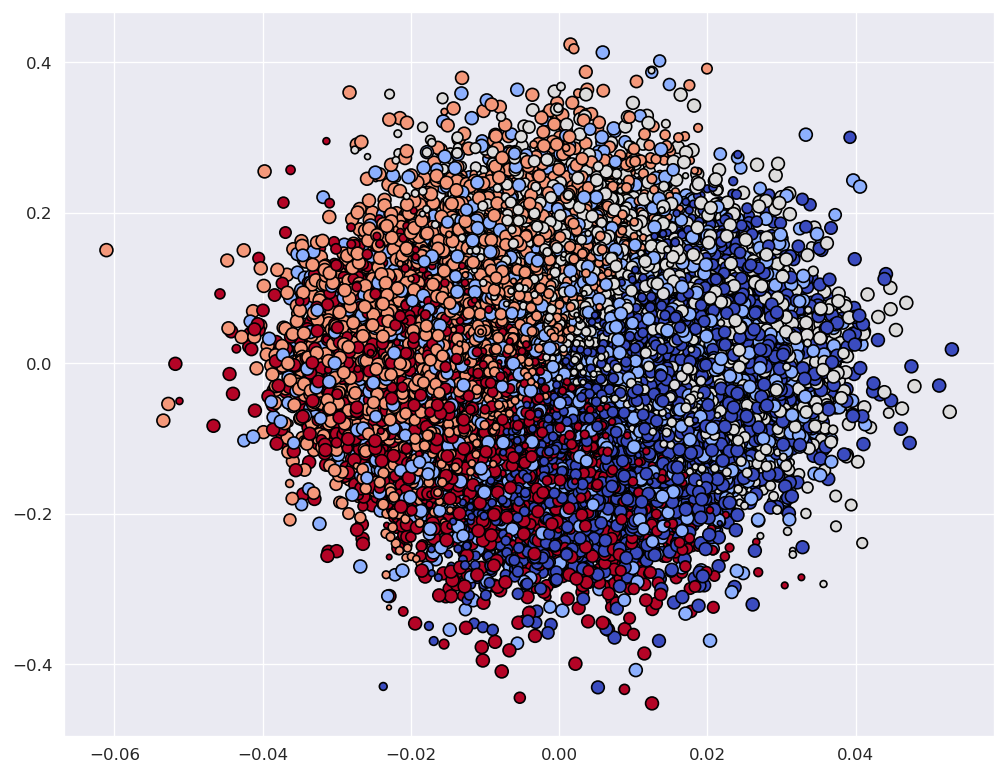

In [ ]:
size = 60 * probs.max(1) ** 2

ax = start_plot(style='darkgrid', dpi=120)
ax.scatter(tdf.iloc[:, x_axis], tdf.iloc[:, y_axis], s=size, 
      c=gmm_labels, edgecolor='k', cmap='coolwarm')

## Metrics: Silhouette score

$s(x_i) = \frac{ b(x_i) - a(x_i)}{ \max \{ a(x_i), b(x_i) \}} , \ it\ is\ clear\ that\ -1 \le s(x_i) \le 1$

i.e, 同群資料點內最近/不同群越分散, 
b為不同群之間的點平均距離，a為同群之間的距離。S越大越好，代表分得越清楚。

Generalization

In [19]:
class ClusterResources():
    def __init__(self, n_k, period=None):
        self.period = period
        self.n_k = n_k

    def standard_data(self):

        df = pd.DataFrame({'diff_B': b_der_all, 'diff_I': i_der_all})
                          
        if self.period is not None:
            b_seasonal = seasonal_decompose(b_der_all, model='additive',
                             period=self.period).seasonal
            i_seasonal = seasonal_decompose(i_der_all, model='additive',
                             period=self.period).seasonal

            df = pd.DataFrame({'diff_B': b_der_all, 'diff_I': i_der_all,
                        'seasonal_B': b_seasonal, 'seasonal_I': i_seasonal})
            

        df_mean = df.mean()
        df_std = df.std()
        std_df = (df - df_mean) / df_std
        X = std_df.values
        return X

    def KMeans_cluster(self):
        model = KMeans(n_clusters=self.n_k)
        results = model.fit_predict(self.standard_data())
        score = self.metrics(results)
        return score

    def GMM(self):
        model = GaussianMixture(n_components=self.n_k)
        results = gmm.fit_predict(self.standard_data())
        # probs = gmm.predict_proba(self.standard_data())
        score = self.metrics(results)
        return score
    
    def DBSCAN(self):
        model = DBSCAN(eps=0.85, min_samples=self.n_k)
        results = dbscan_model.fit_predict(self.standard_data())
        score = self.metrics(results)
        return score

    def metrics(self, results):
        sil_avg = silhouette_score(self.standard_data(), results)
        return sil_avg
        


# Naive clustering analysis: 

Only differentiated time series as features, and apply KMeans, DBSCAN, EM

In [ ]:
%%time
from sklearn.metrics import silhouette_samples, silhouette_score

resource = ClusterResources(n_k=5)

KMeans_score = resource.KMeans_cluster()
DBSCAN_score = resource.DBSCAN()
GMM_score = resource.GMM()

Wall time: 4min 11s


Text(0.5, 0, 'silhouette score')

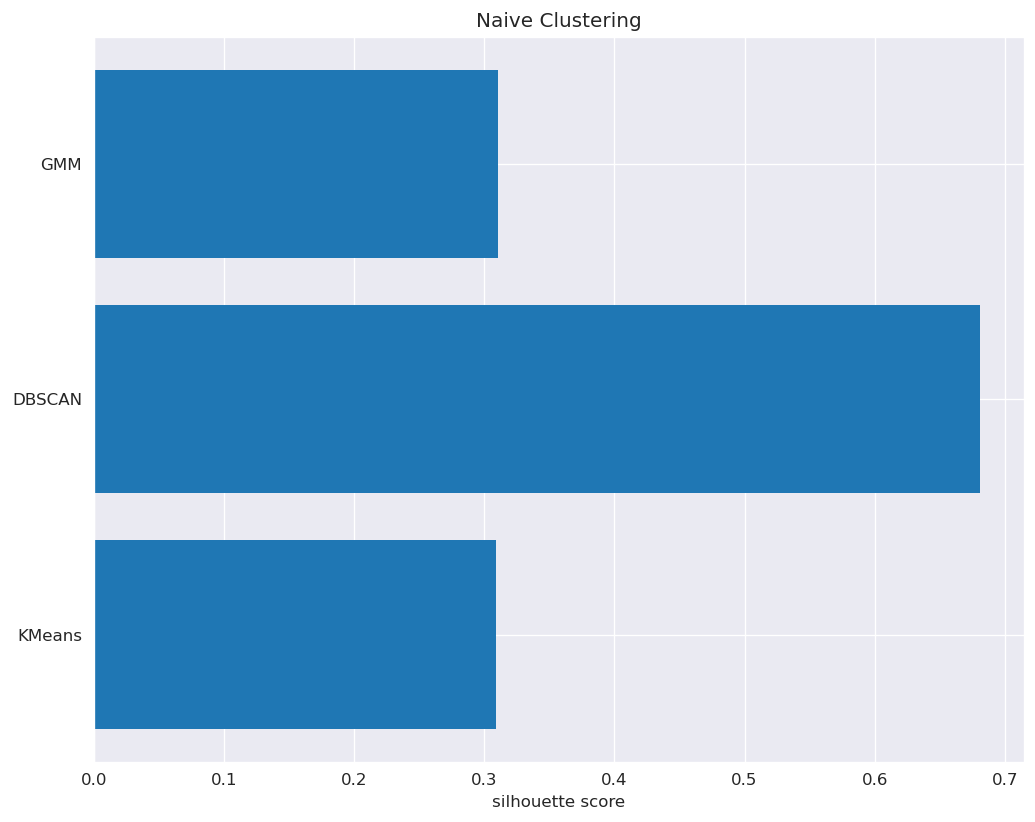

In [ ]:
ax = start_plot(style='darkgrid', dpi=120)
ax.barh(['KMeans', 'DBSCAN', 'GMM'], [KMeans_score, DBSCAN_score, GMM_score])
ax.set_title('Naive Clustering')
ax.set_xlabel('silhouette score')

DBSCAN 表現最好: 平均剪影分數=0.7, 然而DBSCAN因為受$\epsilon$影響很大, 且此資料在feature space中非常密集，容易聚成一類，因此採用EM或KMeans，在此採用EM因為differentiate的分布是類似於white noise的分布

<font color='orange'>DBSCAN 聚成一類證明:<font>

In [27]:
%%time
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.85, min_samples=n_k)
dbscan_labels = dbscan_model.fit_predict(std_train_df.values)

n_clusters_ = len(set(dbscan_labels)) - 1 if -1 in set(dbscan_labels) else 0
n_noise_ = list(dbscan_labels).count(-1)

print('%d estimated clusters' % n_clusters_)
print('%d noise points' % n_noise_)

1 estimated clusters
2 noise points
Wall time: 27.8 s


EM 

In [ ]:
%%time
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_k)
gmm.fit(std_train_df)
gmm_labels = gmm.predict(std_train_df)
probs = gmm.predict_proba(std_train_df)

naive_labels = gmm_labels

Wall time: 643 ms


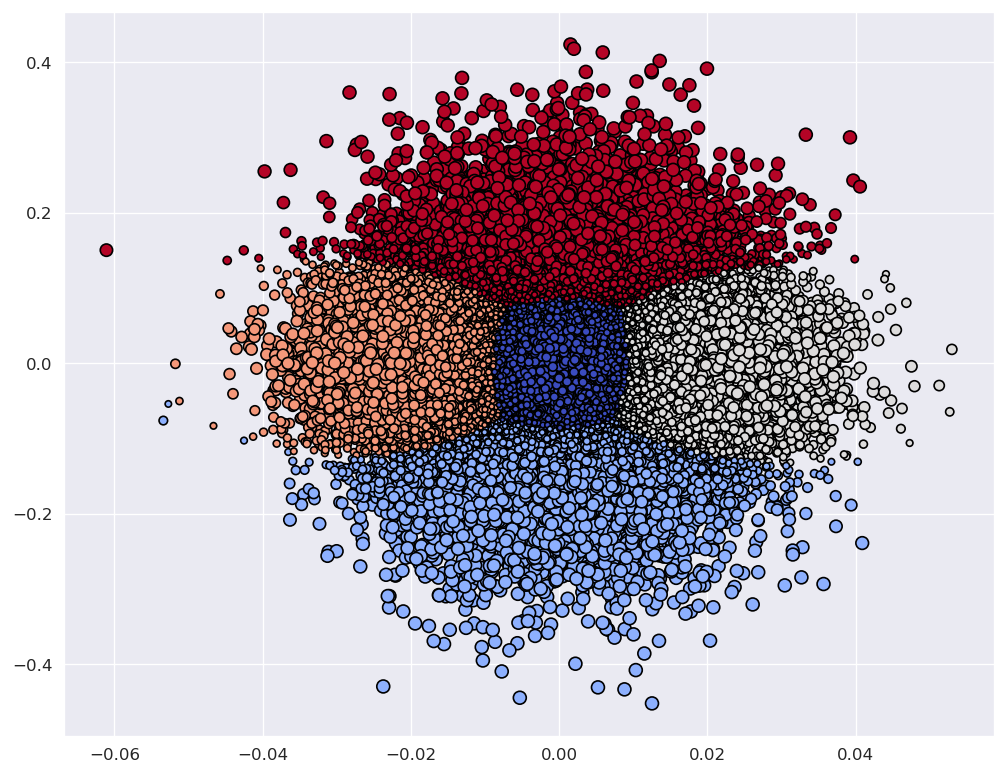

In [ ]:
size = 60 * probs.max(1) ** 2

ax = start_plot(style='darkgrid', dpi=120)
ax.scatter(train_df.iloc[:, 0], train_df.iloc[:, 1], s=size, 
      c=gmm_labels, edgecolor='k', cmap='coolwarm')

In [ ]:
results_df = data.copy()
results_df['diff_B'] = b_der_all
results_df['diff_I'] = i_der_all
results_df['class'] = naive_labels

results_df.head()

XY8002FR  XY8002TI   XY8002PI  TB8002PIB  TB8004PI  \
TIME                                                                       
2021-05-01 00:00:00  82.389222  26.79149  15.947178   8.715559  7.709773   
2021-05-01 00:00:01  82.381760  26.79149  15.941900   8.717367  7.710905   
2021-05-01 00:00:02  82.407649  26.84095  15.948680   8.715977  7.709569   
2021-05-01 00:00:03  82.392084  26.84095  15.950853   8.715723  7.710202   
2021-05-01 00:00:04  82.410602  26.83163  15.948300   8.715945  7.710315   

                     MX8004PIB   MX8004TI   MX8004FR    diff_B    diff_I  \
TIME                                                                       
2021-05-01 00:00:00   2.716009  15.523539  81.789219 -0.007462 -0.093888   
2021-05-01 00:00:01   2.714535  15.539738  81.695330  0.009213 -0.102606   
2021-05-01 00:00:02   2.718486  15.521860  81.584007  0.005162  0.058084   
2021-05-01 00:00:03   2.714572  15.531535  81.811499  0.001476  0.083912   
2021-05-01 00:00:04   2.714224  15.529200  81.751831  0.019010 -0.020449   

                     class  
TIME                        
2021-05-01 00:00:00      1  
2021-05-01 00:00:01      1  
2021-05-01 00:00:02      0  
2021-05-01 00:00:03      0  
2021-05-01 00:00:04      2

In [ ]:
results_df.to_csv(os.path.join(data_dir, 'naive_result.csv'))

# Complicated clustering analysis

設定time window: range from 20 ~ 120

並且introduce KMeans & EM algorithm for grid search

cluster number should always stick to 5 as required

Caution: This would take for a while (>30 min)

In [ ]:
%%time
sil_kmean = []
sil_gmm = []
sil_dbscan = []

range_period = list(range(20, 130, 10))

for i in range_period:
    resource = ClusterResources(period=i, n_k=5)
    sil_gmm.append(resource.GMM())
    sil_kmean.append(resource.KMeans_cluster())
    sil_dbscan.append(resource.DBSCAN())

Wall time: 43min 18s


C:\Users\wonglab\.conda\envs\Q\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


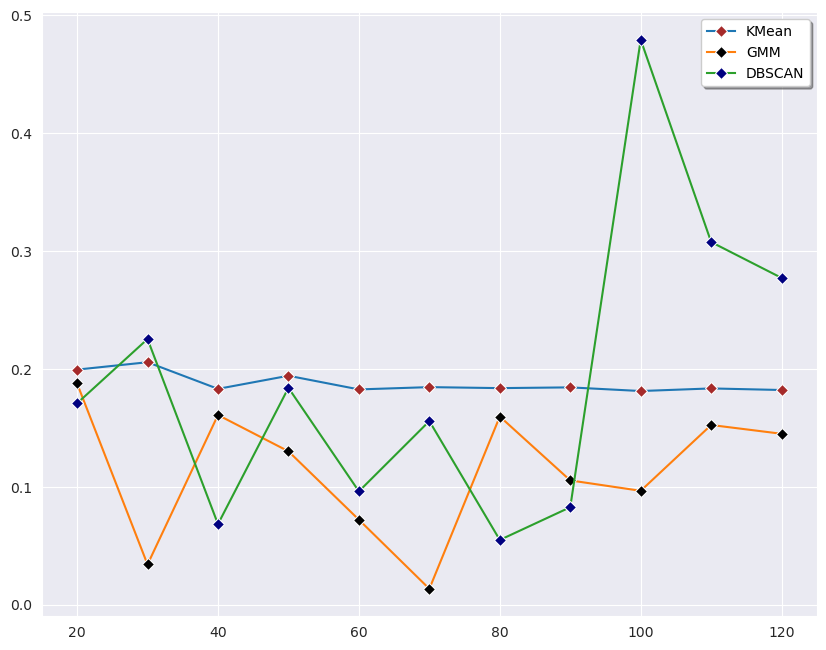

In [ ]:
ax = start_plot(style='darkgrid')
sns.lineplot(range_period, sil_kmean, marker='D', mfc='brown', label='KMean')
sns.lineplot(range_period, sil_gmm, marker='D', mfc='k', label='GMM')
sns.lineplot(range_period, sil_dbscan, marker='D', mfc='navy', label='DBSCAN')

ax.legend(shadow=True)

# Conclusion

- KMeans 表現平平, 最好的model是以20和30秒作為週期取得的seasonality

- GMM 呈現較為劇烈的震盪，但最好的time window也是20, 大部分都比KMeans來的差

- DBSCAN也有劇烈震盪，但在取time window=100時，其clustering效果出奇的好-->觀察

## DBSCAN time window=100 表現最好:

但同上，DBSCAN因為資料過於密集而使得clustering效果有待商榷

In [ ]:
%%time

best_resource = ClusterResources(period=100, n_k=5)

df = best_resource.standard_data()

best_model = DBSCAN(eps=0.85, min_samples=n_k)
best_dbscan_labels = best_model.fit_predict(df)

5 estimated clusters
39 noise points


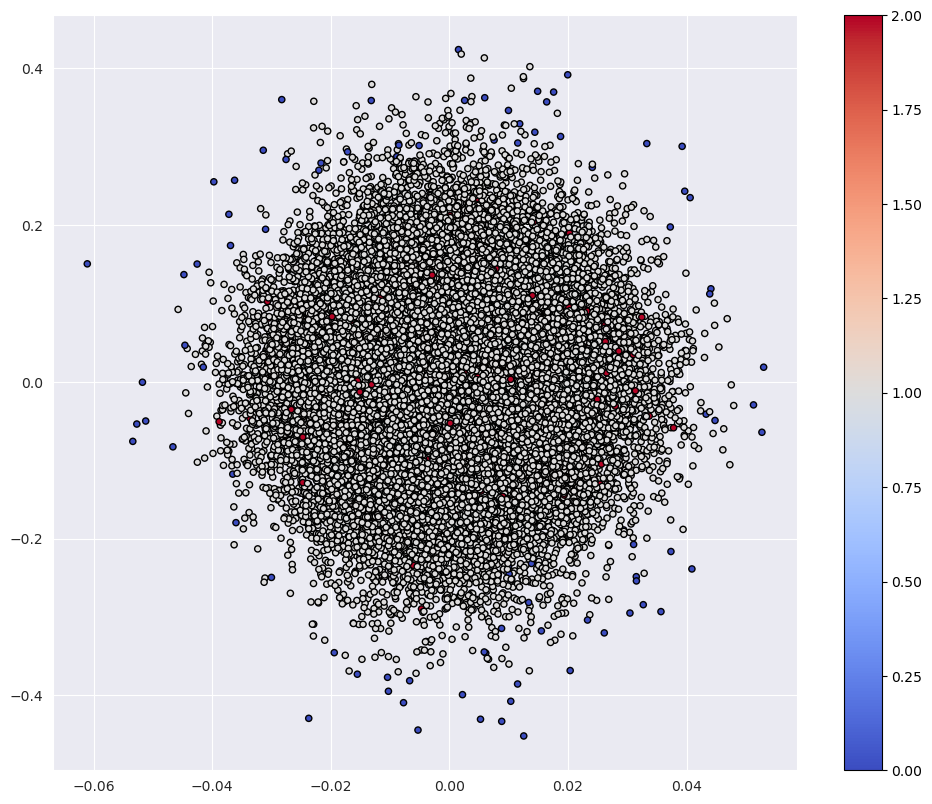

In [ ]:
best_clusters_ = len(set(best_dbscan_labels)) - 1 if -1 in set(best_dbscan_labels) else 0
best_noise_ = list(best_dbscan_labels).count(-1)

print('%d estimated clusters' % n_clusters_)
print('%d noise points' % n_noise_)

best_labels = np.array([x + 1 for x in best_model.labels_])

## Axis for visualization
x_axis = 0
y_axis = 1

ax = start_plot(style='darkgrid', figsize=(12, 10))
scatter_plot = ax.scatter(tdf.iloc[:, x_axis], tdf.iloc[:, y_axis], s=20, edgecolor='k',
           c=best_labels, cmap='coolwarm')
plt.colorbar(scatter_plot, ax=ax)
for c, p in zip(labels, tdf):
    if c != 0:
        continue
    ax.scatter(p[x_axis], p[y_axis], color='yellow', marker='X', s=100, edgecolor='yellow')

## EM time window = 20 表現最好

In [22]:
from sklearn.mixture import GaussianMixture

best_resource = ClusterResources(period=20, n_k=5)

df = best_resource.standard_data()

gmm = GaussianMixture(n_components=5)
gmm.fit(df)
gmm_labels = gmm.predict(df)
probs = gmm.predict_proba(df)

comp_labels = gmm_labels

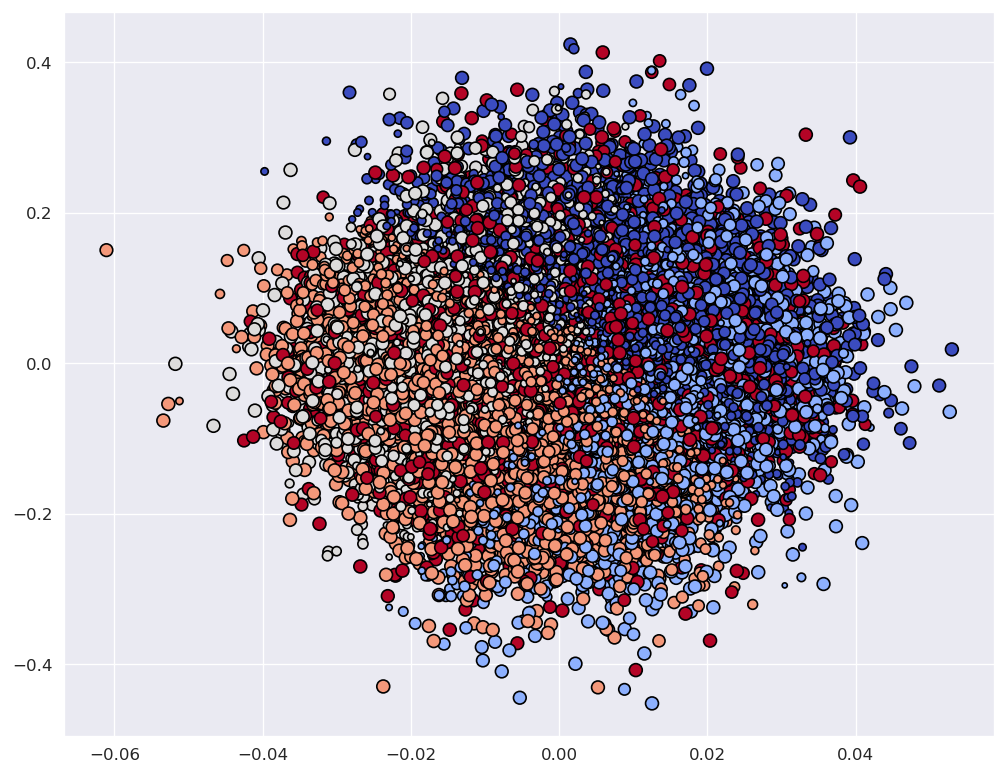

In [23]:
size = 60 * probs.max(1) ** 2

ax = start_plot(style='darkgrid', dpi=120)
ax.scatter(tdf.iloc[:, 0], tdf.iloc[:, 1], s=size, 
      c=comp_labels, edgecolor='k', cmap='coolwarm')

In [25]:
comp_df = data.copy()
comp_df['diff_B'] = b_der_all
comp_df['diff_I'] = i_der_all
comp_df['B_seasonality'] = b_seasonal
comp_df['I_seasonality'] = i_seasonal
comp_df['class'] = comp_labels

comp_df.head()

XY8002FR  XY8002TI   XY8002PI  TB8002PIB  TB8004PI  \
TIME                                                                       
2021-05-01 00:00:00  82.389222  26.79149  15.947178   8.715559  7.709773   
2021-05-01 00:00:01  82.381760  26.79149  15.941900   8.717367  7.710905   
2021-05-01 00:00:02  82.407649  26.84095  15.948680   8.715977  7.709569   
2021-05-01 00:00:03  82.392084  26.84095  15.950853   8.715723  7.710202   
2021-05-01 00:00:04  82.410602  26.83163  15.948300   8.715945  7.710315   

                     MX8004PIB   MX8004TI   MX8004FR    diff_B    diff_I  \
TIME                                                                       
2021-05-01 00:00:00   2.716009  15.523539  81.789219 -0.007462 -0.093888   
2021-05-01 00:00:01   2.714535  15.539738  81.695330  0.009213 -0.102606   
2021-05-01 00:00:02   2.718486  15.521860  81.584007  0.005162  0.058084   
2021-05-01 00:00:03   2.714572  15.531535  81.811499  0.001476  0.083912   
2021-05-01 00:00:04   2.714224  15.529200  81.751831  0.019010 -0.020449   

                     B_seasonality  I_seasonality  class  
TIME                                                      
2021-05-01 00:00:00       0.000098       0.000313      3  
2021-05-01 00:00:01       0.000020      -0.002024      1  
2021-05-01 00:00:02       0.000245      -0.002382      1  
2021-05-01 00:00:03      -0.000002       0.000123      0  
2021-05-01 00:00:04      -0.000197       0.002745      0

In [26]:
comp_df.to_csv(os.path.join(data_dir, 'complicated_result.csv'))